## The Setup

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from pytrends.request import TrendReq
import time
import math
pytrend = TrendReq(hl='en-US', tz=360)
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
#import PokemonData using pandas
#including popularity of each pokemon found in a reddit thread
pokemonData=pd.read_csv('SourceData/PokemonDataV2 - DistinctCheck.csv', header = 0)

pokemonDataUnmodified = []

with open("SourceData/PokemonDataV2 - DistinctCheck.csv", "r") as data_file:
    for row in data_file:
        tempRow = row.strip()
        tempRow = tempRow.split(",")
        pokemonDataUnmodified.append(list(tempRow))

In [15]:
pokemonDataUnmodified[0:9]

[['Ndex',
  'PokÃ©mon',
  'Variance',
  'Generation',
  'Evolution',
  'Rarity',
  'Popularity',
  'NewSnap'],
 ['1', 'Bulbasaur', '', '1', '1', 'Starter', '710', '1'],
 ['2', 'Ivysaur', '', '1', '2', 'Starter', '83', '0'],
 ['3', 'Venusaur', '', '1', '3', 'Starter', '127', '1'],
 ['4', 'Charmander', '', '1', '1', 'Starter', '374', '1'],
 ['5', 'Charmeleon', '', '1', '2', 'Starter', '70', '0'],
 ['6', 'Charizard', '', '1', '3', 'Starter', '1107', '1'],
 ['7', 'Squirtle', '', '1', '1', 'Starter', '523', '1'],
 ['8', 'Wartortle', '', '1', '2', 'Starter', '133', '0']]

## Working the Data

In [16]:
#delete row with headers

del pokemonDataUnmodified[0]
pokemonDataUnmodified[0:9]

[['1', 'Bulbasaur', '', '1', '1', 'Starter', '710', '1'],
 ['2', 'Ivysaur', '', '1', '2', 'Starter', '83', '0'],
 ['3', 'Venusaur', '', '1', '3', 'Starter', '127', '1'],
 ['4', 'Charmander', '', '1', '1', 'Starter', '374', '1'],
 ['5', 'Charmeleon', '', '1', '2', 'Starter', '70', '0'],
 ['6', 'Charizard', '', '1', '3', 'Starter', '1107', '1'],
 ['7', 'Squirtle', '', '1', '1', 'Starter', '523', '1'],
 ['8', 'Wartortle', '', '1', '2', 'Starter', '133', '0'],
 ['9', 'Blastoise', '', '1', '3', 'Starter', '410', '1']]

In [17]:
#remove columns that will not be used. name isn't needed and Ndex is a primary key (more or less)
pokemonData = pokemonData.drop(['Pokémon'], axis=1) 
pokemonData = pokemonData.drop(['Ndex'], axis=1) 

#change data in each column to include what column they are in
#this will be VERY useful later on
pokemonData['Variance'] = 'Variance_' + pokemonData['Variance']
pokemonData['Generation'] = 'Generation_' + pokemonData['Generation'].astype(str)
pokemonData['Evolution'] = 'Evolution_' + pokemonData['Evolution'].astype(str)
pokemonData['Rarity'] = 'Rarity_' + pokemonData['Rarity']

#change the NewSnap column to 0/1, only include initially included in game (no DLC)
def newSnapCheck(data):
  if data['NewSnap'] == 1:
    return 1
  else:
    return 0

#fill in nan values in popularity because decision tree needs values on all spots. going with zero. 
def popularityCheck(data):
  if math.isnan(data['Popularity']):
    return 0
  else:
    return data['Popularity']

pokemonData['NewSnap'] = pokemonData.apply(newSnapCheck, axis=1)
pokemonData['Popularity'] = pokemonData.apply(popularityCheck, axis=1)

In [18]:
#do one hot encoding (aka dummy variables in pandas) on categorical columns

variance_occurance = pokemonData['Variance']
variance_occurance = pd.Series(variance_occurance)
variance_dummy = pd.get_dummies(variance_occurance)

generation_occurance = pokemonData['Generation']
generation_occurance = pd.Series(generation_occurance)
generation_dummy = pd.get_dummies(generation_occurance)

evolution_occurance = pokemonData['Evolution']
evolution_occurance = pd.Series(evolution_occurance)
evolution_dummy = pd.get_dummies(evolution_occurance)

rarity_occurance = pokemonData['Rarity']
rarity_occurance = pd.Series(rarity_occurance)
rarity_dummy = pd.get_dummies(rarity_occurance)

In [19]:
#attach the dummy variables
pokemonData = pd.concat([pokemonData, variance_dummy], axis=1)
pokemonData = pd.concat([pokemonData, generation_dummy], axis=1)
pokemonData = pd.concat([pokemonData, evolution_dummy], axis=1)
pokemonData = pd.concat([pokemonData, rarity_dummy], axis=1)

#remove the categorical columns
pokemonData = pokemonData.drop(['Variance'], axis=1) 
pokemonData = pokemonData.drop(['Generation'], axis=1) 
pokemonData = pokemonData.drop(['Evolution'], axis=1) 
pokemonData = pokemonData.drop(['Rarity'], axis=1) 

In [20]:
pokemonData.head(9)

,Popularity,NewSnap,Variance_Alohan,Variance_Galarian,Variance_Multiple,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,...,Evolution_0,Evolution_1,Evolution_2,Evolution_3,Rarity_Ancient,Rarity_Legendary,Rarity_Mythical,Rarity_Standard,Rarity_Starter,Rarity_Sub-Legendary
0,710.0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,83.0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,127.0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,374.0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,70.0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,1107.0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6,523.0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
7,133.0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8,410.0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Backwards Elimination

In [21]:
pokemonData.columns

Index(['Popularity', 'NewSnap', 'Variance_Alohan', 'Variance_Galarian',
       'Variance_Multiple', 'Generation_1', 'Generation_2', 'Generation_3',
       'Generation_4', 'Generation_5', 'Generation_6', 'Generation_7',
       'Generation_8', 'Evolution_0', 'Evolution_1', 'Evolution_2',
       'Evolution_3', 'Rarity_Ancient', 'Rarity_Legendary', 'Rarity_Mythical',
       'Rarity_Standard', 'Rarity_Starter', 'Rarity_Sub-Legendary'],
      dtype='object')

In [25]:
#ols had issues with the '-' in the column name. Changed column name to get it to work
pokemonData.columns = pokemonData.columns.str.replace('Rarity_Sub-Legendary', 'Rarity_SubLegendary')

In [26]:
#For all sms models, use the dataframe loan_reg.
#Using est = smf.ols(formula='y ~ X variables, data).fit() run a multiple regression.  Name it est.
OLSCheck = smf.ols(formula='NewSnap ~ Popularity +\
Variance_Alohan + Variance_Galarian +\
Variance_Multiple + Generation_1 +\
Generation_2 + Generation_3 +\
Generation_4 + Generation_5 +\
Generation_6 + Generation_7 +\
Generation_8 + Evolution_0 +\
Evolution_1 + Evolution_2 +\
Evolution_3 + Rarity_Ancient +\
Rarity_Legendary + Rarity_Mythical +\
Rarity_Standard + Rarity_Starter +\
Rarity_SubLegendary', data= pokemonData).fit()
OLSCheck.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NewSnap   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.213
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           4.73e-12
Time:                        09:10:06   Log-Likelihood:                -457.13
No. Observations:                 898   AIC:                             954.3
Df Residuals:                     878   BIC:                             1050.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0866      0.021      4.196      0.000       0.046       0.127
Popularity              0.0008      0.000      5.613      0.000       0.001       0.001
Variance_Alohan         0.3107      0.105      2.951      0.003       0.104       0.517
Variance_Galarian      -0.0727      0.099     -0.733      0.464      -0.267       0.122
Variance_Multiple       0.8247      0.409      2.015      0.044       0.021       1.628
Generation_1           -0.0480      0.036     -1.327      0.185      -0.119       0.023
Generation_2            0.0821      0.039      2.114      0.035       0.006       0.158
Generation_3            0.0098      0.034      0.289      0.772      -0.057       0.076
Generation_4            0.0203      0.037      0.546      0.585      -0.053       0.093
Generation_5           -0.0175      0.032     -0.549      0.583      -0.080       0.045
Generation_6            0.0927      0.044      2.086      0.037       0.005       0.180
Generation_7            0.0484      0.042      1.163      0.245      -0.033       0.130
Generation_8           -0.1012      0.041     -2.479      0.013      -0.181      -0.021
Evolution_0             0.1092      0.032      3.371      0.001       0.046       0.173
Evolution_1             0.0010      0.024      0.042      0.966      -0.047       0.049
Evolution_2            -0.0117      0.024     -0.488      0.625      -0.059       0.035
Evolution_3            -0.0119      0.036     -0.334      0.739      -0.082       0.058
Rarity_Ancient          0.1275      0.074      1.717      0.086      -0.018       0.273
Rarity_Legendary       -0.1128      0.076     -1.490      0.136      -0.261       0.036
Rarity_Mythical         0.0225      0.080      0.283      0.777      -0.134       0.179
Rarity_Standard         0.0965      0.032      3.007      0.003       0.034       0.159
Rarity_Starter          0.1325      0.051      2.581      0.010       0.032       0.233
Rarity_SubLegendary    -0.1796      0.060     -2.990      0.003      -0.298      -0.062
==============================================================================
Omnibus:                      129.614   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.138
Skew:                           1.107   Prob(JB):                     3.81e-41
Kurtosis:                       2.727   Cond. No.                     1.47e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.85e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- Analyze the summary statistics and conduct the steps to eliminate all non-significant models
- After all of the variables with p-values above 0.05 are eliminated, 
- Analyze the final model and give some insight into the results

In [27]:
OLSCheck = smf.ols(formula='NewSnap ~ Popularity +\
Variance_Alohan +\
Variance_Multiple +\
Generation_2 +\
Generation_6 +\
Generation_8 + Evolution_0 +\
Rarity_Standard + Rarity_Starter +\
Rarity_SubLegendary', data= pokemonData).fit()
OLSCheck.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NewSnap   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.096
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           2.13e-14
Time:                        09:18:26   Log-Likelihood:                -461.29
No. Observations:                 898   AIC:                             944.6
Df Residuals:                     887   BIC:                             997.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1083      0.057      1.915      0.056      -0.003       0.219
Popularity              0.0007      0.000      5.625      0.000       0.000       0.001
Variance_Alohan         0.2693      0.101      2.678      0.008       0.072       0.467
Variance_Multiple       0.7882      0.407      1.935      0.053      -0.011       1.588
Generation_2            0.0850      0.044      1.928      0.054      -0.002       0.172
Generation_6            0.0957      0.051      1.867      0.062      -0.005       0.196
Generation_8           -0.1021      0.047     -2.174      0.030      -0.194      -0.010
Evolution_0             0.1035      0.042      2.440      0.015       0.020       0.187
Rarity_Standard         0.0674      0.056      1.214      0.225      -0.042       0.176
Rarity_Starter          0.1116      0.073      1.531      0.126      -0.031       0.255
Rarity_SubLegendary    -0.1844      0.078     -2.361      0.018      -0.338      -0.031
==============================================================================
Omnibus:                      133.366   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.019
Skew:                           1.131   Prob(JB):                     7.40e-43
Kurtosis:                       2.734   Cond. No.                     3.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
OLSCheck = smf.ols(formula='NewSnap ~ Popularity +\
Variance_Alohan +\
Generation_8 + Evolution_0 +\
Rarity_SubLegendary', data= pokemonData).fit()
OLSCheck.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NewSnap   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     15.51
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           1.19e-14
Time:                        09:19:45   Log-Likelihood:                -467.70
No. Observations:                 898   AIC:                             947.4
Df Residuals:                     892   BIC:                             976.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1969      0.018     11.046      0.000       0.162       0.232
Popularity              0.0008      0.000      6.251      0.000       0.001       0.001
Variance_Alohan         0.2465      0.101      2.451      0.014       0.049       0.444
Generation_8           -0.1201      0.046     -2.590      0.010      -0.211      -0.029
Evolution_0             0.0776      0.039      2.003      0.045       0.002       0.154
Rarity_SubLegendary    -0.2433      0.068     -3.577      0.000      -0.377      -0.110
==============================================================================
Omnibus:                      136.078   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.277
Skew:                           1.142   Prob(JB):                     8.80e-44
Kurtosis:                       2.705   Cond. No.                         947.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Remove Statistically Non-significant Variables

In [30]:
#get the dataset to only include the columns that were statistically significant
pokemonData.columns

Index(['Popularity', 'NewSnap', 'Variance_Alohan', 'Variance_Galarian',
       'Variance_Multiple', 'Generation_1', 'Generation_2', 'Generation_3',
       'Generation_4', 'Generation_5', 'Generation_6', 'Generation_7',
       'Generation_8', 'Evolution_0', 'Evolution_1', 'Evolution_2',
       'Evolution_3', 'Rarity_Ancient', 'Rarity_Legendary', 'Rarity_Mythical',
       'Rarity_Standard', 'Rarity_Starter', 'Rarity_SubLegendary'],
      dtype='object')

In [31]:
pokemonData = pokemonData.drop(['Variance_Galarian'], axis=1) 
pokemonData = pokemonData.drop(['Variance_Multiple'], axis=1) 
pokemonData = pokemonData.drop(['Generation_1'], axis=1) 
pokemonData = pokemonData.drop(['Generation_2'], axis=1) 
pokemonData = pokemonData.drop(['Generation_3'], axis=1) 
pokemonData = pokemonData.drop(['Generation_4'], axis=1) 
pokemonData = pokemonData.drop(['Generation_5'], axis=1) 
pokemonData = pokemonData.drop(['Generation_6'], axis=1) 
pokemonData = pokemonData.drop(['Generation_7'], axis=1) 
pokemonData = pokemonData.drop(['Evolution_1'], axis=1) 
pokemonData = pokemonData.drop(['Evolution_2'], axis=1) 
pokemonData = pokemonData.drop(['Evolution_3'], axis=1)
pokemonData = pokemonData.drop(['Rarity_Ancient'], axis=1)
pokemonData = pokemonData.drop(['Rarity_Legendary'], axis=1)
pokemonData = pokemonData.drop(['Rarity_Mythical'], axis=1)
pokemonData = pokemonData.drop(['Rarity_Standard'], axis=1)
pokemonData = pokemonData.drop(['Rarity_Starter'], axis=1)

pokemonData.columns

Index(['Popularity', 'NewSnap', 'Variance_Alohan', 'Generation_8',
       'Evolution_0', 'Rarity_SubLegendary'],
      dtype='object')

## Train the Model

In [32]:
#separate the NewSnap column to test for it
y = pokemonData['NewSnap']
X = pokemonData.drop(['NewSnap'], axis=1)

In [33]:
#split the data for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [34]:
#check to make sure the columns look clean in training
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 246 to 132
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Popularity           628 non-null    float64
 1   Variance_Alohan      628 non-null    uint8  
 2   Generation_8         628 non-null    uint8  
 3   Evolution_0          628 non-null    uint8  
 4   Rarity_SubLegendary  628 non-null    uint8  
dtypes: float64(1), uint8(4)
memory usage: 12.3 KB


In [35]:
#check to make sure the columns look clean in testing
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 186 to 311
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Popularity           270 non-null    float64
 1   Variance_Alohan      270 non-null    uint8  
 2   Generation_8         270 non-null    uint8  
 3   Evolution_0          270 non-null    uint8  
 4   Rarity_SubLegendary  270 non-null    uint8  
dtypes: float64(1), uint8(4)
memory usage: 5.3 KB


In [36]:
#do a decision tree classifier based on the training sets
classifier=DecisionTreeClassifier()
classifier=classifier.fit(X_train,y_train)

In [37]:
#use the created prediction model on the testing set
predictions = classifier.predict(X_test)

## Results

In [38]:
#check results of the decision tree
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       201
           1       0.44      0.22      0.29        69

    accuracy                           0.73       270
   macro avg       0.61      0.56      0.56       270
weighted avg       0.69      0.73      0.69       270



In [39]:
#get confusion matrix for counts
print(confusion_matrix(y_test,predictions))

[[182  19]
 [ 54  15]]


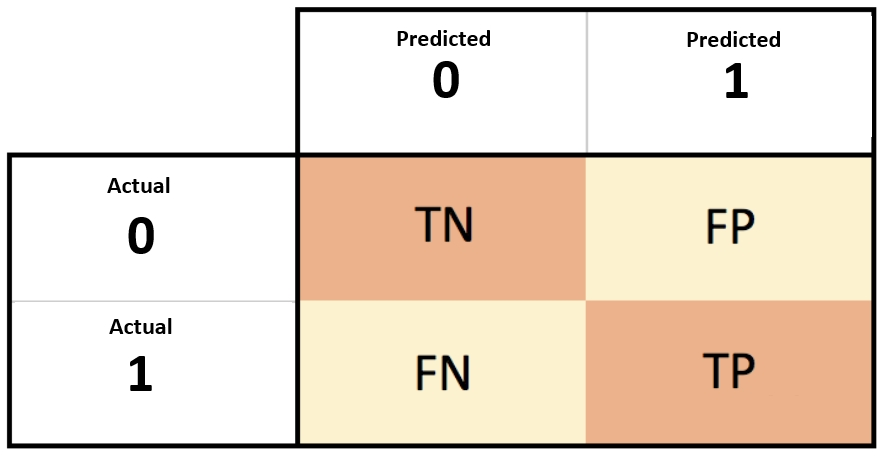

In [40]:
#find importance based off classifier
dt_fi = pd.DataFrame(classifier.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp = pd.concat([dt_fi, names], axis = 1)

df_feat_imp.columns = ['Importance', 'Features']
df_feat_imp.sort_values('Importance', ascending = False)

,Importance,Features
0,0.843397,Popularity
3,0.104383,Evolution_0
1,0.028623,Variance_Alohan
4,0.022510,Rarity_SubLegendary
2,0.001086,Generation_8


The original model had a 70% accuracy. Elimination caused a 3% increase in accuracy. It also uses a lot less memory when having to calculate the model since there are only 5 variables being used.

## Random Forest

In [41]:
#Import
from sklearn.ensemble import RandomForestClassifier

In [42]:
#Run a random forst using the following code:
rf = RandomForestClassifier(n_estimators = 90, max_depth = 10)
rf = rf.fit(X_train, y_train)

In [43]:
#Print Scores
score = rf.score(X_test, y_test)
print(score)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))

0.7185185185185186
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       201
           1       0.37      0.14      0.21        69

    accuracy                           0.72       270
   macro avg       0.56      0.53      0.52       270
weighted avg       0.66      0.72      0.67       270

[[184  17]
 [ 59  10]]


Changing the model type to random forest didn't seem to do anything to improve the accuracy.

## Logistic Regression

In [44]:
#Import
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [45]:
#Create a Logistic Regression classifier using:
logr = LogisticRegression()
logr.fit(X_train, y_train)
score = logr.score(X_test, y_test)
print(score)

0.7481481481481481


In [46]:
#Create a predicted variable from X_test
log_pred = logr.predict(X_test)

In [47]:
#Print confusion matrix and classification report
print(confusion_matrix(y_test, log_pred))
print("")
print(classification_report(y_test, log_pred))

[[197   4]
 [ 64   5]]

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       201
           1       0.56      0.07      0.13        69

    accuracy                           0.75       270
   macro avg       0.66      0.53      0.49       270
weighted avg       0.70      0.75      0.67       270



Logistic regression was better at predicting which Pokemon where going to be excluded from the game, but had a harder time predicting which would be included. 75% accuracy, but it seemed to favor categorizing Pokemon to not being included. Only 5 Pokemon where accurately predicted to be in the game.

## Logistic Regression with Standard Scalar

In [53]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()

In [54]:
#Create scaled sets of the X dataframe
X_scaled = scaler.fit_transform(X)

In [55]:
#Split the data for test/train for the scaled dataframe
X_trainSC, X_testSC, y_trainSC, y_testSC = train_test_split(X_scaled, y, test_size = 0.3, random_state = 25)

In [56]:
#Rerun a logistic regression using the standard scalar datasets.
logr = LogisticRegression()
logr.fit(X_trainSC, y_trainSC)
score = logr.score(X_trainSC, y_trainSC)
print(score)

0.7818471337579618


In [59]:
log_predSC = logr.predict(X_testSC)

In [64]:
#Print the score, confusion matrix, and classification report
print(confusion_matrix(y_testSC, log_predSC))
print("")
print(classification_report(y_testSC, log_predSC))

[[197   4]
 [ 64   5]]

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       201
           1       0.56      0.07      0.13        69

    accuracy                           0.75       270
   macro avg       0.66      0.53      0.49       270
weighted avg       0.70      0.75      0.67       270



Logistic Regression with Standard Scalar had the exact same results as regular Logistic Regression.